In [217]:
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
import xgboost as gb
import sklearn as sk
import sklearn.datasets
import sklearn.svm
import sklearn.ensemble
import sklearn.metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from plotnine import *

### Load data

In [169]:
iris = sk.datasets.load_iris()
X_train, X_test, y_train, y_test = train_test_split(
    iris.data, iris.target, test_size = 0.3, random_state=1334
)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

### Train model

In [208]:
svc = sk.svm.SVC()
svc.fit(X_train, y_train)

rfc = sk.ensemble.RandomForestClassifier()
rfc.fit(X_train, y_train)

gb_params = {
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss',
    'num_class': 3,
}
dtrain = gb.core.DMatrix(X_train, label = y_train)
gbc = gb.train(gb_params, dtrain)

### Prediction

In [219]:
print(iris.target_names)

pred_test_svc = svc.predict(X_test)
print(sk.metrics.confusion_matrix(y_test, pred_test_svc))

pred_test_rfc = rfc.predict(X_test)
print(sk.metrics.confusion_matrix(y_test, pred_test_rfc))

pred_test_gb = gbc.predict(gb.core.DMatrix(X_test))
print(sk.metrics.confusion_matrix(y_test, pred_test_gb))

#pred = svc.predict(iris.data)
#pred = rfc.predict(iris.data)
pred = np.array(gbc.predict(gb.core.DMatrix(iris.data))).astype(int)

print(sk.metrics.confusion_matrix(iris.target, pred))

['setosa' 'versicolor' 'virginica']
[[17  0  0]
 [ 0 16  0]
 [ 0  0 12]]
[[17  0  0]
 [ 0 16  0]
 [ 0  1 11]]
[[17  0  0]
 [ 0 16  0]
 [ 0  0 12]]
[[50  0  0]
 [ 0 49  1]
 [ 0  0 50]]


### Visualize

In [249]:
K = 4
pca = PCA(n_components=K)
pca.fit(iris.data.T)

PCA(n_components=4)

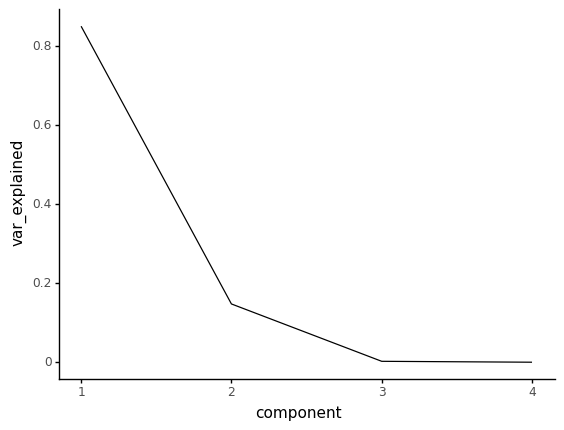

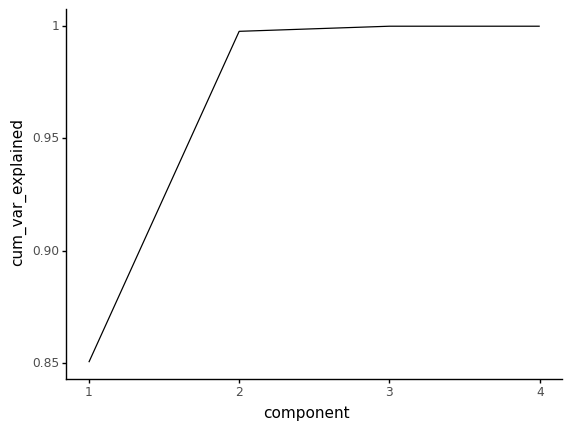

In [248]:
df = pd.DataFrame(
    {
        'component': list(range(1, pca.n_components_+1)),
        'var_explained': pca.explained_variance_ratio_,
        'cum_var_explained': np.cumsum(pca.explained_variance_ratio_)
    }
)
print(
    ggplot(df, aes(x='component', y='var_explained')) + theme_classic() +
        geom_line()
)
print(
    ggplot(df, aes(x='component', y='cum_var_explained')) + theme_classic() +
        geom_line()
)

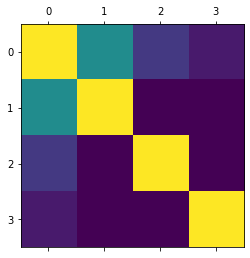

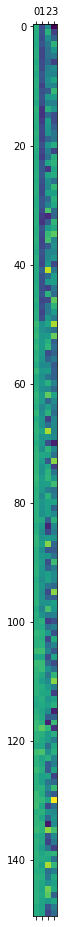

In [239]:
pca_C = np.corrcoef(pca.components_)
pl.matshow(pca_C)
pl.show()

pl.matshow(pca.components_.T)
pl.show()

In [245]:
print(pca.components_.T.shape)

df = pd.DataFrame(
    pca.components_.T,
    columns = ['pc{}'.format(k+1) for k in range(pca.n_components_)]
)
df = pd.concat(
    [df, pd.DataFrame(
        {
            'truth': iris.target_names[iris.target],
            'prediction': iris.target_names[pred],
        }
    )],
    axis = 1
)
df['disconcordant'] = df['truth'] != df['prediction']
df

(150, 4)


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [200]:
def _pca_plot(dim1, dim2):
    return (
        ggplot(df,
            aes(x = dim1, y = dim2,
                fill='truth', colour='prediction',
                shape='disconcordant'
               )) + 
        theme_classic() +
        geom_point() +
        guides(colour=False)
    )

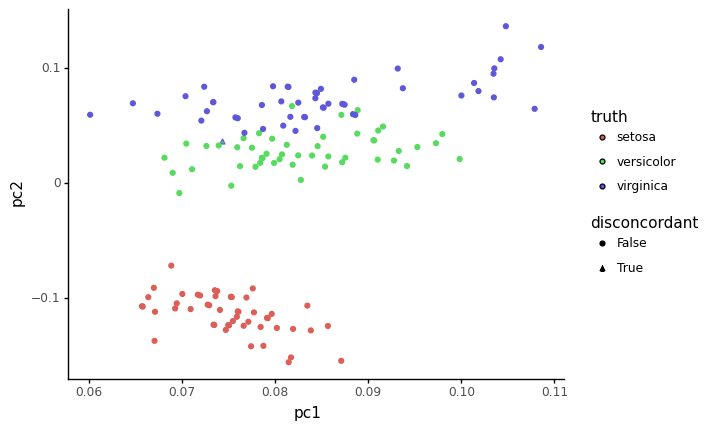

In [201]:
print(_pca_plot('pc1', 'pc2'))

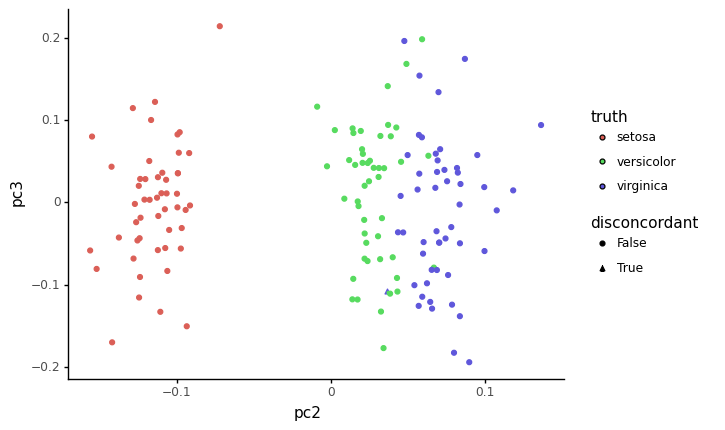

In [202]:
print(_pca_plot('pc2', 'pc3'))

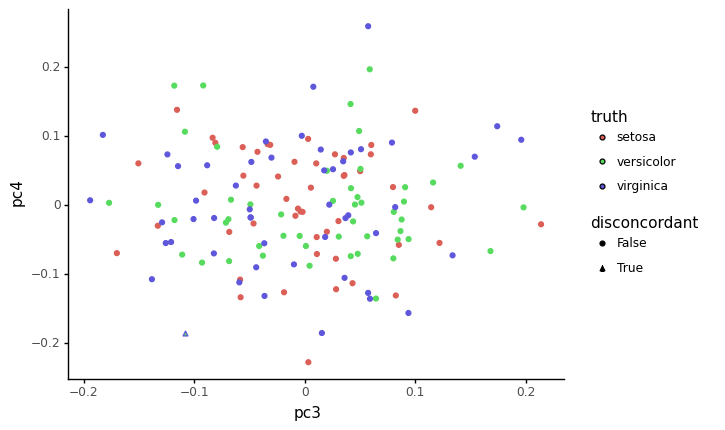

In [203]:
print(_pca_plot('pc3', 'pc4'))

#### Visualize gradient boosted tree

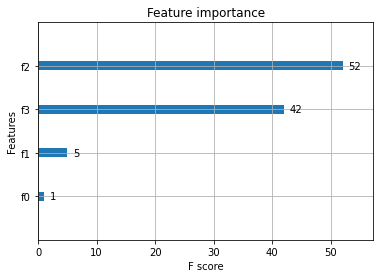

In [232]:
# features: SepalLength SepalWidth PetalLength PetalWidth
gb.plot_importance(gbc)
pl.show()